In [1]:
import csv
from datetime import timedelta
import gurobipy as gp 
from gurobipy import GRB
import networkx as nx
import random
import matplotlib.pyplot as plt
import inspect
from collections import defaultdict

from models import simple_mpc, mpc_duration_constr, lazy, column_generation
from helper import Service, hhmm2mins, mins2hhmm, fetch_data, draw_graph_with_edges, node_legal, no_overlap, create_duty_graph, extract_nodes, generate_paths, roster_statistics, solution_verify, solve_RMLP, new_duty_with_bellman_ford

In [2]:
import importlib
import models
import helper

importlib.reload(models)
importlib.reload(helper)

from models import simple_mpc, mpc_duration_constr, lazy, column_generation
from helper import Service, hhmm2mins, mins2hhmm, fetch_data, draw_graph_with_edges, node_legal, no_overlap, create_duty_graph, extract_nodes, generate_paths, roster_statistics, solution_verify, solve_RMLP, new_duty_with_bellman_ford

In [3]:
services, service_dict = fetch_data('./StepBackServices.csv', partial=True, rakes=3)       # 46 maximum number of rakes
graph = create_duty_graph(services)
print(graph)

DiGraph with 46 nodes and 173 edges


In [4]:
init_duties, duty_count = mpc_duration_constr(graph, service_dict, time_limit = 30, show_logs = True, show_duties = False, show_roster_stats = True)
init_duties2 = init_duties.copy()
# init_duties2 = []
# for duty in init_duties:
#     init_duties2.append([-2] + duty + [-1])
# print(init_duties2[:3])

Set parameter Username
Set parameter LicenseID to value 2626143
Academic license - for non-commercial use only - expires 2026-02-21
Set parameter TimeLimit to value 30


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 697 rows, 392 columns and 1732 nonzeros
Model fingerprint: 0x05ed2bf3
Variable types: 219 continuous, 173 integer (173 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Found heuristic solution: objective 26.0000000
Presolve removed 165 rows and 104 columns
Presolve time: 0.02s
Presolved: 532 rows, 288 columns, 1816 nonzeros
Variable types: 203 continuous, 85 integer (85 binary)

Root relaxation: objective 6.012441e+00, 241 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node

In [5]:
objectives = column_generation(method=1, graph = graph, services = services, init_duties= init_duties2, num_iter = 200, threshold=0.3)

Iteration 0
Optimal solution found
Objective Value: 8.0
Iteration 1
Optimal solution found
Objective Value: 8.0
Iteration 2
Optimal solution found
Objective Value: 8.0
Iteration 3
Optimal solution found
Objective Value: 8.0
Iteration 4
Optimal solution found
Objective Value: 8.0
Iteration 5
Optimal solution found
Objective Value: 8.0
Iteration 6
Optimal solution found
Objective Value: 8.0
Iteration 7
Optimal solution found
Objective Value: 8.0
Iteration 8
Optimal solution found
Objective Value: 8.0
Iteration 9
Optimal solution found
Objective Value: 8.0
Iteration 10
Optimal solution found
Objective Value: 8.0
Iteration 11
Optimal solution found
Objective Value: 7.888888888888886
Iteration 12
Optimal solution found
Objective Value: 7.666666666666666
Iteration 13
Optimal solution found
Objective Value: 7.5
Iteration 14
Optimal solution found
Objective Value: 7.454545454545453
Iteration 15
Optimal solution found
Objective Value: 7.375
Iteration 16
Optimal solution found
Objective Value: 7

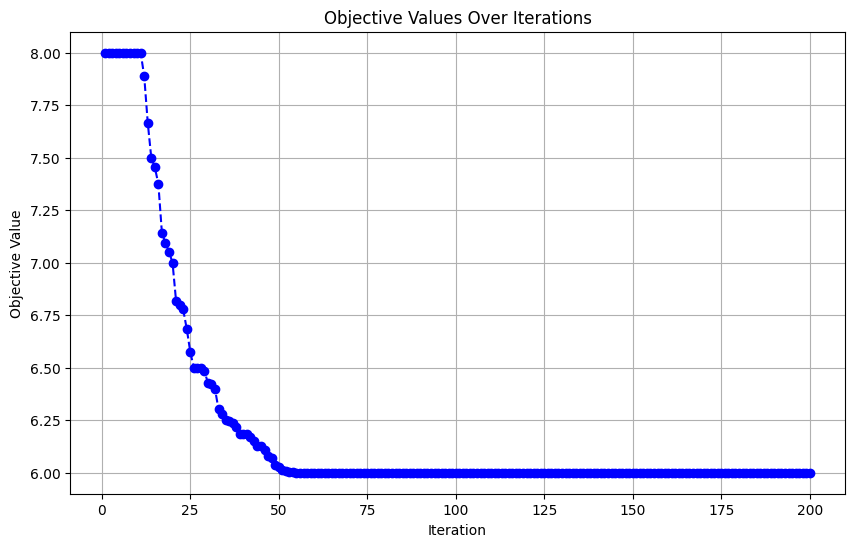

In [6]:
iterations = range(1, len(objectives) + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations, objectives, marker='o', linestyle='--', color='b')
plt.title('Objective Values Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.grid(True)
plt.show()

In [ ]:
def rounding_heuristic(services, duties, duty_vars, model):
    """
    Applies rounding heuristic to the fractional solution obtained from RMLP.

    Arguments:
        services - list of Service objects,
        duties - list of duties,
        duty_vars - list of Gurobi variables corresponding to the duties,
        model - Gurobi model object after solving RMLP

    Returns:
        selected_duties - list of selected duties (integers),
        feasible - boolean indicating if the solution is feasible
    """
    selected_duties = []
    
    # Step 1: Round variables close to 0 or 1
    for idx, var in enumerate(duty_vars):
        if var.x >= 0.9:   # Close to 1
            selected_duties.append(1)
        elif var.x <= 0.1: # Close to 0
            selected_duties.append(0)
        else:
            selected_duties.append(round(var.x))  # Round to nearest integer

    # Step 2: Check feasibility
    service_coverage = [0] * len(services)
    for duty_idx, duty in enumerate(duties):
        if selected_duties[duty_idx] == 1:
            for service in services:
                if service.serv_num in duty:
                    service_coverage[service.serv_num] += 1
    
    # Step 3: Ensure all services are covered
    feasible = True
    for coverage in service_coverage:
        if coverage < 1:  # If any service is not covered
            feasible = False
            break

    # Step 4: If infeasible, adjust by adding minimum duties to cover gaps
    if not feasible:
        print("Initial rounding resulted in infeasible solution. Adjusting...")
        for service_idx, coverage in enumerate(service_coverage):
            if coverage < 1:  # If service is not covered
                # Find the least costly duty that covers the uncovered service
                min_cost = float('inf')
                best_duty = None
                for duty_idx, duty in enumerate(duties):
                    if selected_duties[duty_idx] == 0 and services[service_idx].serv_num in duty:
                        cost = duty_vars[duty_idx].obj  # Objective value (cost) of the duty
                        if cost < min_cost:
                            min_cost = cost
                            best_duty = duty_idx
                # Add the best duty to cover the service
                if best_duty is not None:
                    selected_duties[best_duty] = 1
    
    # Recheck feasibility after adjustment
    service_coverage = [0] * len(services)
    for duty_idx, duty in enumerate(duties):
        if selected_duties[duty_idx] == 1:
            for service in services:
                if service.serv_num in duty:
                    service_coverage[service.serv_num] += 1
    
    feasible = all(coverage >= 1 for coverage in service_coverage)
    
    if feasible:
        print("Feasible integer solution obtained.")
    else:
        print("Failed to obtain a feasible integer solution.")
    
    return selected_duties, feasible


selected_duties_rounded, feasible = rounding_heuristic(services, init_duties2, selected_duties_vars, model=None)

    # Print the results
print("Selected Duties (Rounded):", selected_duties_rounded)
print("Is the solution feasible?", feasible)

NameError: name 'duties' is not defined